In [2]:
import ROOT
import pandas
import numpy as np
np.random.seed(1234)

filename = "BDT.root"
# Specify variables which shall be used as input for the neural network
#variables = ["mPt", "ePt", "e_m_collinearMass", "e_m_visibleMass", "dPhiMuMET", "dPhiEMET", "dPhiMuE", "MTMuMET"]
variables = ["mPt", "e_m_collinearMass", "e_m_visibleMass", "MTMuMET"]

def load_tree(filename, treename):
    f = ROOT.TFile(filename)
    t = f.Get(treename)
    data, labels = t.AsMatrix(columns=variables + ["weight"], return_labels=True)
    return pandas.DataFrame(data=data, columns=labels)

# Load data from ROOT TTrees to panda dataframes
signal = load_tree(filename, "TreeS")
background = load_tree(filename, "TreeB")

# Show the content of a dataframe
#print(background)
print(signal)

               mPt  e_m_collinearMass  e_m_visibleMass     MTMuMET    weight
0        64.575668          85.694244        80.866974   88.195625  0.010295
1        74.411705          90.077950        58.455322  174.503708  0.007238
2        51.121700          86.194260        75.913574   75.019348  0.007472
3        66.392273         108.557671        87.526779   97.436249  0.011913
4        37.547386         163.797623       104.089790   99.525703  0.011086
5        69.857529         111.128197       105.674881   71.267563  0.011732
6        94.891556         101.316582        95.157402   58.381340  0.014577
7        68.106529          76.882645        65.263977  101.595390  0.012351
8        87.530128         113.597305        96.794991  141.464447  0.011823
9        24.612665         110.253372        96.582870   45.693783  0.009994
10       65.840721          99.813370        97.726830   78.982620  0.012682
11       30.667974         129.072052        96.520271   64.654190  0.007615

In [3]:
# Sum of all event weights is needed for reweighting to equal importance
sum_weights = np.sum(signal["weight"]) + np.sum(background["weight"])

# Function to reweight the weights to equal importance
def reweight(df):
    df["weight_reweighted"] = df["weight"] * sum_weights / np.sum(df["weight"])

# Run the reweighting on the pandas dataframe
reweight(signal)
reweight(background)

In [4]:
import matplotlib.pyplot as plt

# Function to plot a variable
def plot(variable):
    plt.figure()
    range_ = np.percentile(signal[variable], (5, 95))
    plt.hist(
        [signal[variable], background[variable]],
        range=range_,
        #bins=30,
        weights=[
            signal["weight_reweighted"],
            background["weight_reweighted"]],
        histtype="step",
        lw=2,
        label=("signal", "background"))
    plt.xlabel(variable)
    plt.legend()

# Loop over variables and plot each one
for var in variables:
    plot(var)

In [5]:
# Function to extract numpy array from pandas dataframe
def load_data(df, index):
    x = df.as_matrix(columns=variables)
    w = df.as_matrix(columns=["weight_reweighted"])
    y = np.zeros((x.shape[0], 2))
    y[:, index] = 1
    return x, w, y

# Load data from dataframe to numpy arrays
signal_x, signal_w, signal_y = load_data(signal, 0)
background_x, background_w, background_y = load_data(background, 1)

# Stack numpy arrays of different processes to single array
x = np.vstack([signal_x, background_x])
w = np.vstack([signal_w, background_w]).squeeze()
y = np.vstack([signal_y, background_y])

# Print what we are doing
print("Variables:\n{}\n".format(variables))
print("Inputs:\n{}\n".format(x))
print("Weights:\n{}\n".format(w))
print("Targets:\n{}\n".format(y))

/cvmfs/sft.cern.ch/lcg/views/LCG_94/x86_64-centos7-gcc8-opt/lib/python2.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/cvmfs/sft.cern.ch/lcg/views/LCG_94/x86_64-centos7-gcc8-opt/lib/python2.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


Variables:
['mPt', 'e_m_collinearMass', 'e_m_visibleMass', 'MTMuMET']

Inputs:
[[ 64.57566833  85.69424438  80.86697388  88.19562531]
 [ 74.41170502  90.07794952  58.45532227 174.50370789]
 [ 51.12170029  86.19425964  75.91357422  75.01934814]
 ...
 [ 41.7135582  100.82290649  80.40729523  10.51107979]
 [ 35.07635117  83.57242584  49.60738373  96.80285645]
 [ 24.6069355   57.62071991  40.49722672  55.49817657]]

Weights:
[1.89809964 1.33453159 1.37767332 ... 0.03852997 0.02481124 0.01877601]

Targets:
[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]



In [6]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

# Stack layers defining neural network architecture
model = Sequential()
model.add(Dense(100, activation="relu", input_dim=len(variables)))
model.add(Dropout(0.2))
model.add(Dense(2, activation="softmax"))

# Specify loss function and optimizer algorithm
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])

# Print architecture
model.summary()

Using Theano backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               500       
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 202       
Total params: 702
Trainable params: 702
Non-trainable params: 0
_________________________________________________________________


In [7]:
from sklearn.model_selection import train_test_split

# Split dataset in training and validation part used for the gradient steps and monitoring of the training
x_train, x_val, y_train, y_val, w_train, w_val = train_test_split(x, y, w, test_size=0.5, random_state=1234)

# Train the neural network
history = model.fit(
                x_train, y_train,
                sample_weight=w_train,
                batch_size=1000,
                epochs=10,
                validation_data=(x_val, y_val, w_val))

Train on 2530923 samples, validate on 2530924 samples
Epoch 1/10
2530923/2530923 [==============================] - 49s 19us/step - loss: 0.0500 - acc: 0.7327 - val_loss: 0.0331 - val_acc: 0.8545
Epoch 2/10
2530923/2530923 [==============================] - 48s 19us/step - loss: 0.0333 - acc: 0.8741 - val_loss: 0.0325 - val_acc: 0.8636
Epoch 3/10
2530923/2530923 [==============================] - 47s 19us/step - loss: 0.0322 - acc: 0.8881 - val_loss: 0.0302 - val_acc: 0.9513
Epoch 4/10
2530923/2530923 [==============================] - 49s 19us/step - loss: 0.0277 - acc: 0.8240 - val_loss: 0.0323 - val_acc: 0.4854
Epoch 5/10
2530923/2530923 [==============================] - 48s 19us/step - loss: 0.0256 - acc: 0.7763 - val_loss: 0.0228 - val_acc: 0.8194
Epoch 6/10
2530923/2530923 [==============================] - 47s 19us/step - loss: 0.0225 - acc: 0.8427 - val_loss: 0.0186 - val_acc: 0.9263
Epoch 7/10
2530923/2530923 [==============================] - 48s 19us/step - loss: 0.0214 - a

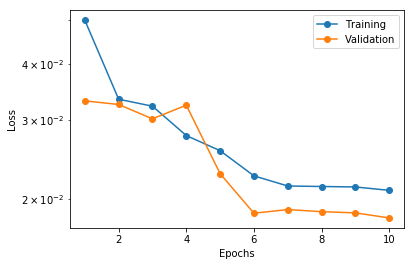

In [8]:
# Extract number of run epochs from the training history
epochs = range(1, len(history.history["loss"])+1)

# Extract loss on training and validation dataset and plot them together
plt.plot(epochs, history.history["loss"], "o-", label="Training")
plt.plot(epochs, history.history["val_loss"], "o-", label="Validation")
plt.xlabel("Epochs"), plt.ylabel("Loss")
plt.yscale("log")
plt.legend();

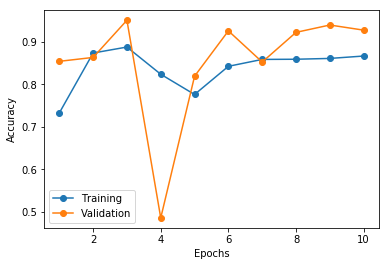

In [9]:
# Extract number of run epochs from the training history
epochs = range(1, len(history.history["loss"])+1)

# Extract accuracy on training and validation dataset and plot them together
plt.plot(epochs, history.history["acc"], "o-", label="Training")
plt.plot(epochs, history.history["val_acc"], "o-", label="Validation")
plt.xlabel("Epochs"), plt.ylabel("Accuracy")
plt.legend();

In [10]:
# Get neural network prediction for each MC sample
signal_predictions = model.predict(signal_x)
background_predictions = model.predict(background_x)

# Print predictions showing probability for each process
print("Predictions of signal events:\n{}\n".format(
    signal_predictions))
print("Mean probability per process:\n{}\n".format(
    np.mean(signal_predictions, axis=0)))

Predictions of signal events:
[[0.86676365 0.13323636]
 [0.57900655 0.42099345]
 [0.83887774 0.16112228]
 ...
 [0.8593135  0.14068651]
 [0.00569495 0.9943051 ]
 [0.20815952 0.7918405 ]]

Mean probability per process:
[0.7203854  0.27959988]



In [11]:
# These are our processes
processes = ["signal", "background"]

# Structure categories
categories = {}
for category in processes: # Make dedicated category for each process
    categories[category] = {}
    for process in processes: # Store NN scores and event weights of each process contributing to this category
        categories[category][process] = {"scores": [], "weights": []}

predictions = {
    "signal": signal_predictions,
    "background": background_predictions
}
weights = {
    "signal": signal["weight"],
    "background": background["weight"]
}

# Loop over processes
for i_process, process in enumerate(processes):
    # Loop over events of this process
    n_events = predictions[process].shape[0]
    for i_event in range(n_events):
        # Find category for this event and retrieve NN score
        p = predictions[process][i_event] # e.g., [0.3, 0.5, 0.2]
        max_index = np.argmax(p)          #             1
        max_score = p[max_index]          #             0.5
        category = processes[max_index]   #             "ztt"
        
        # Store NN score and event weight for this event in respective category
        categories[category][process]["scores"].append(
            max_score
        )
        categories[category][process]["weights"].append(
            weights[process][i_event]
        )

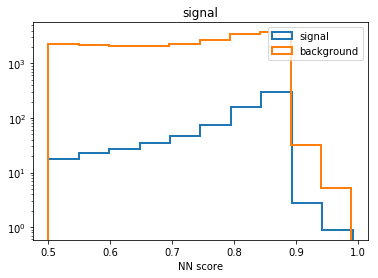

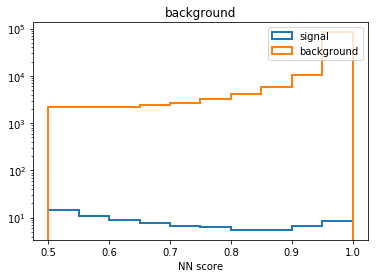

In [12]:
def plot(label, logscale=False):
    category = categories[label]
    plt.figure()
    bins = np.linspace(0.33, 1.0, 10)
    for process in category:
        plt.hist(
            np.array(category[process]["scores"]),
            weights=np.array(category[process]["weights"]),
            #bins=bins,
            histtype="step",
            lw=2,
            label=process)
    plt.title(label)
    plt.xlabel("NN score")
    #plt.xlim((bins[0], bins[-1]))
    if logscale:
        plt.yscale("log")
    plt.legend()
    
# Plot categories
plot("signal", logscale=True)
plot("background", logscale=True)

In [ ]:
model.save('NN.h5')
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights('NN_weights.h5')

In [ ]:
from keras.models import load_model
import numpy as np
model = load_model('NNtf.h5')
#pred = [[38.902351, 30.035307, 2.589421, 0.638355, 20.325911, 89.910355, 0.622604, 0.019863]]
pred = [[85.433296, 43.545998, 2.442940, 0.403881, 14.301805, 135.165955, 49.902340, 3.093282]]
prediction = model.predict(np.array(pred)) 
print prediction